In [1]:
from six.moves import cPickle
import os
import matplotlib.pyplot as plt
import numpy as np
import importlib
import utils as ut
from tqdm import tqdm
import mlpBonus as mlp

ModuleNotFoundError: No module named 'utils'

In [ ]:
K, d, n = 10, 3072, 10000
np.random.seed(42)
mu, sigma = 0, 0.01 
batch_start, batch_end= 0, 20

# Data Preprocessing

In [3]:
def normalize_data(X, mean, std):
    X -= np.outer(mean_X, np.ones(X.shape[1]))
    X /= np.outer(std_X, np.ones(X.shape[1]))
    return X
    
importlib.reload(ut)
X_train, y_train, Y_train = ut.loadData('data_batch_1', clipping=True)
X_val, y_val, Y_val = ut.loadData('data_batch_2', clipping=True)
X_test, y_test, Y_test = ut.loadData('test_batch', clipping=True)

## normalize with mean and std of train set 
mean_X = np.mean(X_train, axis=1)
std_X = np.std(X_train, axis=1)

X_train = normalize_data(X_train, mean_X, std_X)
X_val = normalize_data(X_val, mean_X, std_X)
X_test = normalize_data(X_test, mean_X, std_X)
data = {"X_train": X_train, "y_train": y_train, "Y_train": Y_train, "X_val":X_val, "y_val": y_val, "Y_val": Y_val}

In [4]:
importlib.reload(ut)
X_train_whole, y_train_whole, Y_train_whole = ut.loadData('data_batch_1', clipping=True)

for i in range(2,6):
    X, y, Y = ut.loadData('data_batch_'+str(i), clipping=True)
    X_train_whole = np.concatenate((X, X_train_whole), axis=1)
    y_train_whole = np.concatenate((y, y_train_whole))
    Y_train_whole = np.concatenate((Y, Y_train_whole), axis=1)

n_val = 5000

X_val_small, y_val_small, Y_val_small = X_train_whole[:,-n_val:], y_train_whole[-n_val:], Y_train_whole[:,-n_val:]
X_train_whole, y_train_whole, Y_train_whole = X_train_whole[:,:-n_val], y_train_whole[:-n_val], Y_train_whole[:,:-n_val]

## normalize with mean and std of train set 
mean = np.mean(X_train_whole, axis=1)
std = np.std(X_train_whole, axis=1)

X_train_whole = normalize_data(X_train_whole, mean, std)
X_val_small = normalize_data(X_val_small, mean, std)

data_whole = {"X_train": X_train_whole, "y_train": y_train_whole, "Y_train": Y_train_whole, "X_val":X_val_small, "y_val": y_val_small, "Y_val": Y_val_small}

# Ensemble Learning + Cyclical Learning

In [7]:
importlib.reload(mlp)
net2 = mlp.MLP(lamda=.01)
GDparams = {"n_batch":100, "n_cycles":3, "eta_min":1e-5, "eta_max":1e-1, "ns":800, "freq":8, "exp":"ensemble_learning"}
net2.cyclicLearning(data, GDparams, verbose=True, backup=True)

 33%|███▎      | 16/48 [00:37<01:05,  2.05s/it]Cycle 0 saved
Update Step 0: train_acc=0.6457 | val_acc=0.4617 | train_loss=1.088963501287065 | val_loss=1.5891740307900855 | train_cost=1.3933665120258087 | val_cost=1.8935770415288289
 67%|██████▋   | 32/48 [01:13<00:32,  2.04s/it]Cycle 1 saved
Update Step 0: train_acc=0.6943 | val_acc=0.462 | train_loss=0.9731502339632998 | val_loss=1.5870446014455277 | train_cost=1.334363313435136 | val_cost=1.948257680917364
100%|██████████| 48/48 [01:53<00:00,  2.37s/it]Cycle 2 saved



In [1]:
net2.plot_metric(GDparams, metric="loss")
net2.plot_metric(GDparams, metric="cost")
net2.plot_metric(GDparams, metric="accuracy")

NameError: name 'net2' is not defined

In [9]:
net2.computeAccuracy(X_test, y_test)

0.464

In [12]:
importlib.reload(mlp)
GDparams = {"n_batch":100, "n_cycles":3, "eta_min":1e-5, "eta_max":1e-1, "ns":800, "freq":8, "exp":"ensemble_learning"}
classes, acc = mlp.MLP.majorityVoting(X_test, y_test, GDparams, n_cycle=3, lamda=0.01)
acc

0.4641

# WHOLE DATA

In [26]:
importlib.reload(ut)
X_train_whole, y_train_whole, Y_train_whole = ut.loadData('data_batch_1', clipping=True)
X_test, y_test, Y_test = ut.loadData('test_batch', clipping=True)

for i in range(2,6):
    X, y, Y = ut.loadData('data_batch_'+str(i), clipping=True)
    X_train_whole = np.concatenate((X, X_train_whole), axis=1)
    y_train_whole = np.concatenate((y, y_train_whole))
    Y_train_whole = np.concatenate((Y, Y_train_whole), axis=1)

n_val = 5000

X_val_small, y_val_small, Y_val_small = X_train_whole[:,-n_val:], y_train_whole[-n_val:], Y_train_whole[:,-n_val:]
X_train_whole, y_train_whole, Y_train_whole = X_train_whole[:,:-n_val], y_train_whole[:-n_val], Y_train_whole[:,:-n_val]

## normalize with mean and std of train set 
mean = np.mean(X_train_whole, axis=1)
std = np.std(X_train_whole, axis=1)

X_train_whole = normalize_data(X_train_whole, mean, std)
X_val_small = normalize_data(X_val_small, mean, std)
X_test = normalize_data(X_test, mean_X, std_X)

# Estimate Boundaries

In [13]:
importlib.reload(mlp)
net = mlp.MLP()
etas, accuracies = mlp.MLP.estimateBoundaries(data, eta_min=0.0001, eta_max=0.15, n_search=20, h=50, lamda=0.01)

100%|██████████| 3/3 [00:10<00:00,  3.44s/it]


No handles with labels found to put in legend.


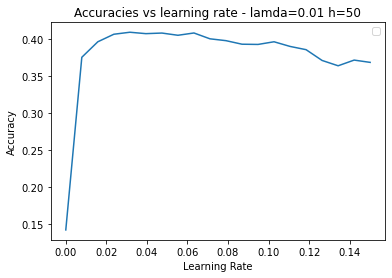

In [13]:
net.plotAccuracies(etas, accuracies, lamda=0.01, h=50)

In [6]:
etas

array([1.00000000e-04, 1.58842105e-02, 3.16684211e-02, 4.74526316e-02,
       6.32368421e-02, 7.90210526e-02, 9.48052632e-02, 1.10589474e-01,
       1.26373684e-01, 1.42157895e-01, 1.57942105e-01, 1.73726316e-01,
       1.89510526e-01, 2.05294737e-01, 2.21078947e-01, 2.36863158e-01,
       2.52647368e-01, 2.68431579e-01, 2.84215789e-01, 3.00000000e-01])

No handles with labels found to put in legend.


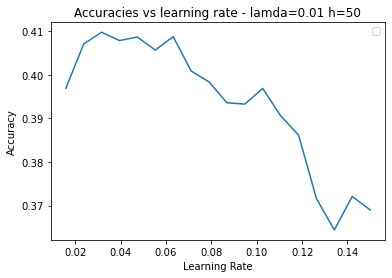

In [15]:
net.plotAccuracies(etas[2:], accuracies[2:], lamda=0.01, h=50)

No handles with labels found to put in legend.


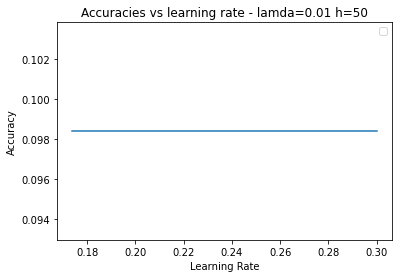

In [10]:
net.plotAccuracies(etas[11:], accuracies[11:], lamda=0.01, h=50)


In [11]:
accuracies

[0.1422,
 0.3983,
 0.408,
 0.4084,
 0.4066,
 0.3963,
 0.399,
 0.384,
 0.3743,
 0.3802,
 0.3636,
 0.0984,
 0.0984,
 0.0984,
 0.0984,
 0.0984,
 0.0984,
 0.0984,
 0.0984,
 0.0984]